## Ensemble Probability with Python ##
**Tyler Wixtrom**<br>
*Texas Tech University*<br>

Unidata Users Workshop<br>
*June 25-28, 2018<br>
Boulder, CO*

In this example, we will compute and plot ensemble probability for simulated reflectivity greater than 25 dBz.


In [1]:
import numpy as np
from netCDF4 import Dataset, num2date
import operator

We will start by reading in the simulated reflectivity data from each ensemble member with the netCDF4-python package and storing the data in a dictionary.

In [2]:
refl = {}
for i in range(1, 21):
    data = Dataset('../2015020112/wrfprst_d01_2015020112_mem'+str(i)+'.nc')
    refl['mem'+str(i)] = data.variables['DBZ'][:].data

In [3]:
lat = data.variables['lat'][0, :]
lon = data.variables['lon'][0, :]
vtimes = num2date(data.variables['valid_time'][:], data.variables['valid_time'].units)

### Ensemble Probability ###
Ensemble probability is a relatively simple calculation and can be acomplished quite easily in python. The probability is simply defined as the number of members meeting a pre-defined criteria (for this example simulated reflectivity greater than 25 dBz) divided by the total number of members. 

In [4]:
def ens_prob(thresh, operator, *args):
    """Computes the ensemble probability"""
    thresh_arg_data = []
    for arg in args:
        data = np.zeros_like(arg)
        data[operator(arg, thresh)] = 1.
        thresh_arg_data.append(data)
    thresh_data = np.stack(thresh_arg_data, axis=0)
    return np.mean(thresh_data, axis=0)

In [5]:
points = ens_prob(25., operator.gt, *[refl[key] for key in refl.keys()])

We will plot the point probabilities with Matplotlib and Cartopy as in previous examples

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up our projection
plotcrs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes',
    scale='50m',
    facecolor='none')

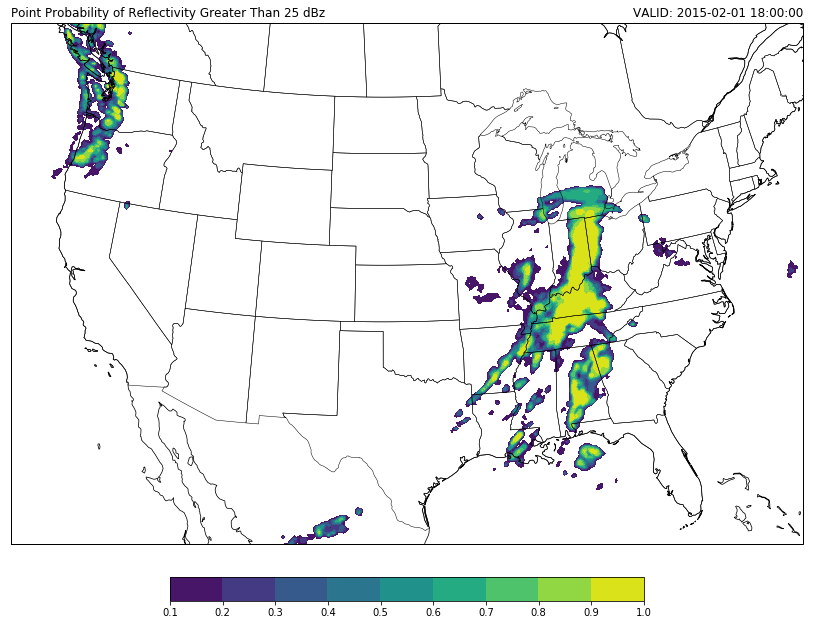

In [7]:
# Choose a time to plot
time = 2

# Set up the figure and add a map background
fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.1, 1.1, 0.1)
cf = ax.contourf(lon, lat, points[time,], contours, transform=ccrs.PlateCarree(), cmap=plt.cm.viridis)
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)
# Make some titles
plt.title('Point Probability of Reflectivity Greater Than 25 dBz', loc='left')
plt.title('VALID: %s' % (vtimes[time]), loc='right')
plt.show()

### Ensemble Probability of Nearby Occurence ###

The above ensemble probability calculation is considered to be defined for a single point. However, this calculation does not account for spatial variability or more generally the chance of occurence nearby to any single point. Therefore, the Neighborhood Mean Ensemble Probability is often used for predicting phenomena such as convection where forecasters are more interested in the chance of nearby occurence rather than the probability of occurence at any single point.

#### Neighborhood Mean Ensemble Probability (NMEP) ####

The most common approach to calculating the probability of occurence within a distance of a single point is reffered to as the Neighborhood Mean Ensemble Probability (NMEP). Is this approach, the probability at each point is first calculated, and the the mean probability of all points within a specified radius is calculated, which is defined as NMEP, or the probability of occurence within the radius of any given point.

### Calculating NMEP ###

We will start by first using cartopy to transform the coordiante latitude and longitude points to x and y in meters by using and equal area projection.

In [8]:
crs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)
tlatlons = crs.transform_points(ccrs.PlateCarree(), lon, lat)
tlons = tlatlons[:, :, 0]
tlats = tlatlons[:, :, 1]

While the transformation from ensemble point probabilities to NMEP is relatively simple, finding all points within the specified radius is rather slow in an interpreted language such as python. To speed this up, we will utilize the numba package (https://numba.pydata.org) which will convert the written python code into compiled C code, which will run much faster.

In [9]:
from numba import njit

@njit
def distance_mask(x, y, x1, y1, r, xshape, yshape):
    """Compute mask of points within the specified radius"""
    num = 0
    xi = []
    yi = []
    for i in range(xshape):
        for j in range(yshape):
            d = ((x[i, j] - x1)**2 + (y[i, j] - y1)**2)**0.5
            if d <= r:
                xi.append(i)
                yi.append(j)
                num += 1.
    return xi, yi, num


@njit
def neighborhood_prob(points, r, x, y):
    """Computes ensemble neighborhood probability"""
    neighbor_probs = np.full_like(points, np.nan)
    tshape, xshape, yshape = points.shape
    for i in range(xshape):
        for j in range(yshape):
            xi, yi, num = distance_mask(x, y, x[i, j], y[i, j], r, xshape, yshape)
            for k in range(tshape):
                point_sum = 0
                for a in range(len(xi)):
                    point_sum += points[k, xi[a], yi[a]]
                neighbor_probs[k, i, j] = point_sum / num
    return neighbor_probs

In [10]:
nprobs = neighborhood_prob(points, 40000, tlons, tlats)

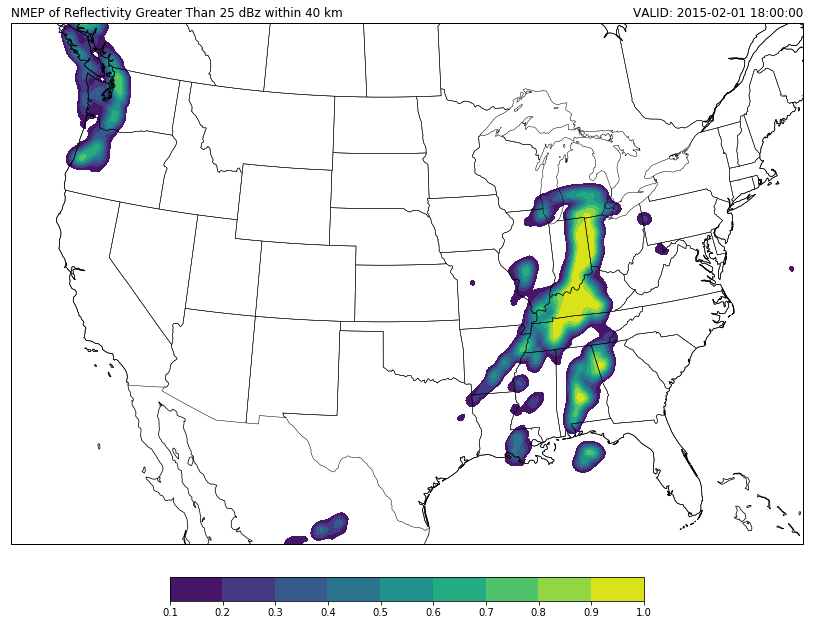

In [11]:
# Choose a time to plot
time = 2

fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.1, 1.1, 0.1)
cf = ax.contourf(lon, lat, nprobs[time, ],
                 contours, transform=ccrs.PlateCarree(), cmap=plt.cm.viridis)
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)
# Make some titles
plt.title('NMEP of Reflectivity Greater Than 25 dBz within 40 km', loc='left')
plt.title('VALID: %s' % (vtimes[time]), loc='right')
plt.show()

### Your Turn! ###

Try creating a plot of either ensemble probabilities or NMEP for updraft helicity (UH) greater than 25 m$^2$s$^{-2}$

In [ ]:
uh = {}
for i in range(1, 21):


In [ ]:
# %load solutions/probability_solution.py